In [1]:
from pathlib import Path
import xarray as xr
import hvplot.xarray
import hvplot.pandas

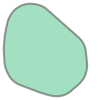

In [2]:
res_id = '0505'

import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

dumboor_pt = val_pts.loc[val_pts['tmsos_id']==res_id]
dumboor_poly = val_polys.loc[val_polys['tmsos_id']==res_id]

buffered_roi = dumboor_poly.geometry.iloc[0].convex_hull.buffer(0.05)
bbox = buffered_roi.bounds
buffered_roi

In [3]:
ds_fps = Path(f'../data/s2/{res_id}').glob('*.nc')

ds = xr.open_mfdataset(ds_fps)
ds

<xarray.Dataset> Size: 728MB
Dimensions:      (y: 2336, x: 1948, time: 10, band: 4, reservoir: 1)
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
  * time         (time) datetime64[ns] 80B 2019-01-02T04:31:51.024000 ... 201...
  * band         (band) <U3 48B 'B04' 'B03' 'B02' 'B08'
  * reservoir    (reservoir) <U4 16B '0505'
    spatial_ref  int64 8B 0
Data variables:
    s2           (reservoir, band, time, y, x) float32 728MB dask.array<chunksize=(1, 4, 1, 2336, 1948), meta=np.ndarray>

In [4]:
def calc_ndwi(da):
    """
    Calculate the Normalized Difference Water Index (NDWI)
    """
    green = da.sel(band="B03")
    nir = da.sel(band="B08")
    return (green - nir) / (green + nir)

ndwi = calc_ndwi(ds['s2'])
ndwi

<xarray.DataArray 's2' (reservoir: 1, time: 10, y: 2336, x: 1948)> Size: 182MB
dask.array<truediv, shape=(1, 10, 2336, 1948), dtype=float32, chunksize=(1, 1, 2336, 1948), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
  * time         (time) datetime64[ns] 80B 2019-01-02T04:31:51.024000 ... 201...
  * reservoir    (reservoir) <U4 16B '0505'
    spatial_ref  int64 8B 0

In [5]:
ndwi.hvplot(x='x', y='y', rasterize=True, cmap='RdYlBu', clim=(-1, 0.3), width=800, height=600, title='NDWI')

BokehModel(combine_events=True, render_bundle={'docs_json': {'d399c1f1-f822-4d3d-aa57-036909670b8c': {'version…

CRS.from_epsg(32646)

In [46]:
ndwi.rio.crs.data['init'].split(':')[-1]

'32646'

In [66]:
dumboor_poly_projected = dumboor_poly.to_crs(ndwi.rio.crs.data['init'])
dumboor_poly_projected_buffered = dumboor_poly_projected.copy()
dumboor_poly_projected_buffered['geometry'] = dumboor_poly_projected.convex_hull.buffer(2000)
dumboor_poly_projected_buffered

,GRAND_ID_left,RES_NAME_left,DAM_NAME_left,ALT_NAME_left,RIVER_left,ALT_RIVER_left,MAIN_BASIN_left,SUB_BASIN_left,NEAR_CITY_left,ALT_CITY_left,...,db,name,rid_id,grand_id,rid_filepath,resops_id,rid_filename,tmsos_id,distance,geometry
82,5121,None,Gumti,None,Gumti,None,Brahmaputra-Meghna,None,Amarpur,None,...,deltares,None,NaN,NaN,None,NaN,None,0505,NaN,"POLYGON ((386807.402 2591115.275, 386653.432 2..."


In [68]:
water_map = ndwi > 0
water_map.hvplot(x='x', y='y', rasterize=True, cmap='Blues', clim=(0, 1), width=500, height=400, title='Water Map', crs=ndwi.rio.crs.data['init'].split(':')[-1]) + \
ndwi.hvplot(x='x', y='y', rasterize=True, cmap='RdYlBu', clim=(-1, 0.3), width=500, height=400, title='NDWI', crs=ndwi.rio.crs.data['init'].split(':')[-1]) * \
dumboor_poly_projected_buffered.hvplot(geo=True, tiles='OSM', alpha=0.5, crs=ndwi.rio.crs.data['init'].split(':')[-1])

BokehModel(combine_events=True, render_bundle={'docs_json': {'ee940208-9844-41aa-b700-6bd65c6c2d14': {'version…

In [74]:
?water_map.rio.clip

Signature:
water_map.rio.clip(
    geometries: collections.abc.Iterable,
    crs: Optional[Any] = None,
    all_touched: bool = False,
    drop: bool = True,
    invert: bool = False,
    from_disk: bool = False,
) -> xarray.core.dataarray.DataArray
Docstring:
Crops a :obj:`xarray.DataArray` by geojson like geometry dicts.

Powered by `rasterio.features.geometry_mask`.

Examples:

    >>> geometry = ''' {"type": "Polygon",
    ...                 "coordinates": [
    ...                 [[-94.07955380199459, 41.69085871273774],
    ...                 [-94.06082436942204, 41.69103313774798],
    ...                 [-94.06063203899649, 41.67932439500822],
    ...                 [-94.07935807746362, 41.679150041277325],
    ...                 [-94.07955380199459, 41.69085871273774]]]}'''
    >>> cropping_geometries = [geojson.loads(geometry)]
    >>> xds = xarray.open_rasterio('cool_raster.tif')
    >>> cropped = xds.rio.clip(geometries=cropping_geometries, crs=4326)


.. versionadded

In [76]:
ndwi_clipped = ndwi.rio.clip(dumboor_poly_projected.geometry.apply(lambda x: x.buffer(2000)))
water_map_clipped = water_map.rio.clip(dumboor_poly_projected.geometry.apply(lambda x: x.buffer(2000)))
# ndwi_clipped.hvplot(x='x', y='y', rasterize=True, cmap='RdYlBu', clim=(-1, 0.3), width=800, height=600, title='NDWI')
water_map_clipped.hvplot(x='x', y='y', rasterize=True, cmap='RdYlBu', clim=(-1, 0.3), width=800, height=600, title='NDWI')

BokehModel(combine_events=True, render_bundle={'docs_json': {'70563c23-3029-4d23-87bd-8add7404bcf0': {'version…

In [23]:
save_dir = Path('../data/area/s2')
save_dir.mkdir(exist_ok=True)

save_fp = save_dir / f'{res_id}.csv'

area = (water_map.sum(dim=['x', 'y']) * 1e2 * 1e-6) # km2
area_df = area.to_dataframe(name='s2 area [km2]').reset_index().drop('spatial_ref', axis=1)

area_df.to_csv(save_fp, index=False)

## temp otsu threshold

In [53]:
import numpy as np

def otsu_intraclass_variance(image, threshold):
    """
    Otsu's intra-class variance.
    If all pixels are above or below the threshold, this will throw a warning that can safely be ignored.
    """
    return np.nansum(
        [
            np.mean(cls) * np.var(image, where=cls)
            #   weight   ·  intra-class variance
            for cls in [image >= threshold, image < threshold]
        ]
    )
    # NaNs only arise if the class is empty, in which case the contribution should be zero, which `nansum` accomplishes.

# image = np.nan_to_num(ndwi.values, -1)
image = ndwi.values

otsu_threshold = min(
    np.linspace(-1, 1, 20),
    key=lambda th: otsu_intraclass_variance(image, th),
)

# val = filters.threshold_otsu(ndwi.values)
# otsu_threshold

In [54]:
otsu_threshold

-0.1578947368421053